# The Numerical Taxonomy of Urban Form

## Urban form is diverse, complex and ever evolving

<div>
<img src="../documents/images/urban_form_patterns.jpg" width="1000"/>
</div>

% include reference

__Urban morphology__ is the study of this form, and aims to answer the following questions:

>_“What the urban form is like, why the urban form is like that, and then how could we make the urban form better for people?”_ - Michael Barke (Northumbria University – Department of Geography and Environment)

Traditionally, the methods of urban morphology are qualitative in nature - as some of you might know if you've got a background in Architecture/Urban Design.

With rapid development in the realm of __Geographic Data Science__, quantitative approaches are gaining momentum.

Among these developments a highly specialised ... of researchers are working on open-source and highly reproducible approaches to studying urban morphology. Software based approaches are usually hard to replicate, and often not adaptable to a specific case. This is not true for code-based approaches such as the one in the use case.

%%REFERENCE FLEISCHMANN WITH THANKS

---
__WHAT WE ARE DOING TODAY__

We will generate the taxonomy of urban form for a dutch city, resulting in a clustering of urban form characteristics.

Why are we interested in this in the first place? Characterising urban form will allow us to explore the relationship between different urban spaces and phenomena such as environmental performance (heat, pollution), health (physical/mental) and plenty more...


Why we need to scale: This type of analysis is heavy on resources. The serial code for the Amsterdam case (~122.000 buildings) takes between 3-4 hours to execute, and we have the need within the group to scale this to potentially hundreds of millions of buildings across multiple countries --> not feasible.

---

__Inputs required__:

- building footprints (incl. height information) as polygons.
- street network as linestrings.

This notebook is adapted from existing code by Martin Fleischmann - and adapted to the Amsterdam use case (CITE the paper). It is reliant on a library for morphometric analysis authored by Fleischmann as well: Momepy. As you will see, most of the functions are momepy functions.

What we will do is the following: 

<div>
<img src="../documents/images/process.jpg" width="1000"/>
</div>






## BUT YOU WERE PROMISED THE 3DBAG?

<div>
<img src="../documents/images/3dbag.png" width="1000"/>
</div>


We are in fact using it: Building footprints are taken straight from the 3dbag (__download script is attached__).


### 3D in 2D? What?

__There are multiple reasons for this:__
- 3D data is important to address a variety of (urban) challenges. It is, however, difficult to work with. 
- 3D is still a relatively new landscape and tools far less developed. We are still working on a lot of the foundations (not so shiny stuff that is hidden under the iceberg)
- There are some resources on 3D morphology - even using the 3DBAG (%CITE Labetsky/Vitalis), but we're still at the beginning.

<div>
<img src="../documents/images/iceberg.png" width="400"/>
</div>

__However, more importantly:__
- We would like to scale this approach to the entire EU building stock, maybe beyond. While we have high quality 3D building models in NL, this is not the case everywhere.
- What is more and more availaible is building height information, in the EU for ~75% of the building stock (see https://eubucco.com/).
- In our case we have likely got some of the most accurate information.

Bottom line for you: 

__The 3DBAG does not only contain 3D data, but also 2D (with added characteristics like building height).__ 

AND

__Not every use case requires a true 3D dataset__. Know that using 2D polygons with height\ information is always an option, and might be enough depending on what your analysis requires.

#### But what is the true height of a building?

Glad you asked. It's a bit more complicated as there are plenty of options to choose from (in 3DBAG). We will work with the 70th percentile as true height.

<div>
<img src="../documents/images/building_heights.jpg" width="1000"/>
</div>

% REFERENCE - ANNA?


## Step 1: Import modules/libraries

In [1]:
import warnings

## suppress warning 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')
# Data cleaning
import operator
# The standard library to handle geospatial data. 
import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
# THE library for morphometric analysis.
import momepy as mm
# Support for large, multi-dimensional arrays and matrices
import numpy as np
# Handling of data, w/o the spatial component.
import pandas as pd
import scipy as sp
# Data visualization library based on matplotlib
import seaborn as sns
#
import dask
import os
#
from dask.distributed import Client
from dask import delayed
from dask.diagnostics import ProgressBar
from scipy.cluster import hierarchy
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
# from owslib.wfs import WebFeatureService
#
# To show all columns in a dataframe. To reset: pd.reset_option(“max_columns”)
pd.set_option('display.max_columns', None) 


path = os.environ["SCALABLE_GIS_DATA_PATH"]

## Step 2: City selection (pending)
For after the workshop

## Step 3: Load and prep buildings

In [ ]:
# Loading Amsterdam neighbourhoods and keeping only one region of interest:
ams = gpd.read_file(path+'AMS_Buurten_lnglat.json').to_crs(28992)
# ams = ams.loc[(ams['Stadsdeelcode']  == 'A')] # Amsterdam center
ams = ams.loc[(ams['Wijkcode']  == 'AJ')]  # you can also try other codes eg AJ01
ams.explore()

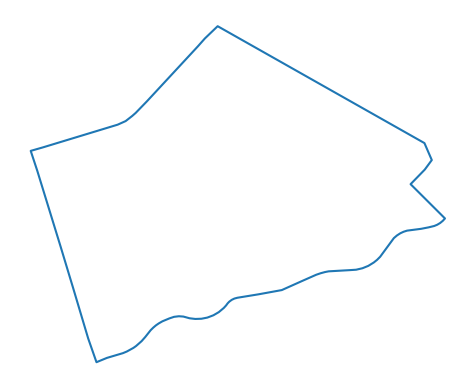

In [3]:
ams_outline = ams.dissolve().boundary
ax = ams_outline.plot()
ax.set_axis_off()

Number of buildings 1156.


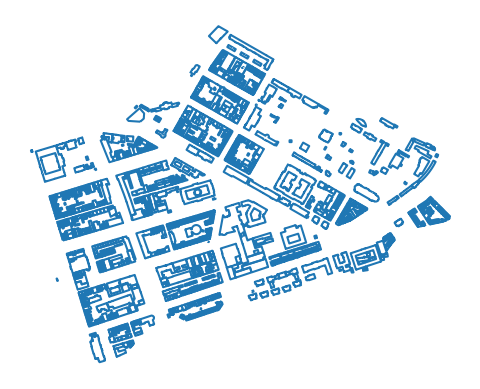

In [4]:
# Loading all amsterdam buildings and keeping only the ones within the amsterdam center
# path = path+"3DBAG/Amsterdam_buildings.gpkg"
buildings = gpd.read_file(path+"3DBAG/Amsterdam_buildings.gpkg", mask = ams)
buildings = buildings.clip(ams)
buildings = buildings[['height_70p','geometry']]
print(f"Number of buildings {len(buildings)}.")
ax = buildings.boundary.plot()
ax.set_axis_off()

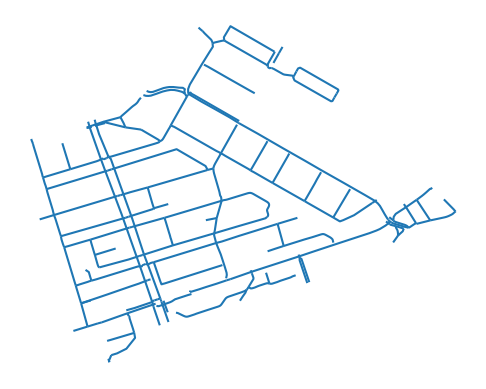

In [5]:
# Loading Street network and keeping only the ones relevant to the chosen neighbourhood
streets = gpd.read_file(path+'ams_wegvakken.gpkg', mask = ams).to_crs(28992)
streets = streets.clip(ams)
streets = streets[streets['FRC'].isin(['1','6'])]
streets = streets[['geometry']] # keep only the geometry column
streets = streets.explode(ignore_index=True) 
ax = streets.plot()
ax.set_axis_off()

__Let's create a persistent unique identifier for each building__

In [7]:
%%time
# Clean up the dataframe. We only need the height and geometry information. 
## Height was already calculated prior to this - the 3DBAG comes with different calculated heights (INCLUDE THE HEIGHT OVERVIEW). 
## We use 70th percentile height because it most accurately represents the true height of the building. 

# Preprocess buildings (clean up small buildings that are likely uninhabitable, and eliminate multipolygons)
buildings = mm.preprocess(buildings, size=30, compactness=0.2, islands=True, loops=2, verbose=False)
assert not buildings.duplicated().any() # Make sure there are no duplicates
# Create a persistent unique identifier for each building
buildings = buildings.reset_index(drop=True)
buildings["uID"] = buildings.index
buildings.head()



CPU times: user 409 ms, sys: 24.4 ms, total: 434 ms
Wall time: 437 ms


,height_70p,geometry,uID
0,19.809489,"POLYGON ((122127.708 485995.252, 122127.648 48...",0
1,18.940560,"POLYGON ((122133.831 486010.542, 122134.604 48...",1
2,18.862777,"POLYGON ((122133.595 486015.055, 122133.730 48...",2
3,18.905282,"POLYGON ((122125.147 486022.705, 122130.000 48...",3
4,17.733721,"POLYGON ((122136.517 486032.502, 122138.490 48...",4


## Step 4: Generate additional morphometric elements

Morphology is usually comprised of three fundamental elements: _buildings, plots, streets_. 

We have buildings and streets, but plots are more complicated because they can have a variety of different configurations and meanings (e.g., multiple buildings on a single plot).

So how do we generate this missing element, respecting contiguity and keeping data reliance at a minimum (remember, we would like to scale this and would like to only have building footprints and roads)?:

__Morphological Tessellation (based on voronoi tessellation - see below)__

<div>
<img src="../documents/images/Euclidean_Voronoi_diagram.svg.png" width="200"/>
</div>

https://en.wikipedia.org/wiki/Voronoi_diagram

The "morphological cell (the result of the tessellation)", is a spatial unit capturing the portion of land around each building which is closer to it than any other, but no further than 100m.

It is used to capture the relations between cells and the influence of a building on the surrounding space.

### The first scalability hurdle:


Momepy includes two approaches to tessellation: Morphological tessellation and enclosed tessellation.


The original approach utilises morphological tessellation, which is great, but painfully slow and NOT easily scalable (> 45 minutes to tessellate AMS)!

Why do I say not scalable? It requires awareness of surrounding buildings.

Let me show you what I mean.

This is the result of the serial implementation. As you can see, all looks neat and tidy. Tessellation cells are maybe a little bit large due to the 100m buffer.

<div>
<img src="../documents/images/morph_tessellation.png" width="800"/>
<!-- <figcaption align = "center"> Serial Implementation </figcaption> -->
</div>

If we try to chunk this and run it in parallel, this is what we get:

<div>
<img src="../documents/images/morph_tessellation_parallel.jpg" width="800"/>
</div>


So what is the issue here?


### So how do we get around this? __Enclosed Tessellation__

We break down the tessellation into a two-step process.

1. We use the boundaries that we have (street network and waterways) to partition the space into 'enclosures'.
<div>
<img src="../documents/images/outline_roads.png" width="1000"/>
</div>
2. Once the space is divided up, we can chunk the morphological tessellation and apply it to each enclosure. 

Why does this enable parallelisation? Each enclosure can be handled separately and does not require awareness of neighbouring enclosures to divide up the space!

__But how do these results compare?__

<div>
<img src="../documents/images/comparison_tessellation.png" width="1000"/>
</div>

#### What do we take away from this?

- Enclosed tessellation more closely resembles actual plots! 
- Because we can run the process in parallel, the computation takes only a fraction of the time. 
- __Issues: Works best with simplified road geometry (centrelines) which we don't have.__

Learning: When selecting/developing your method, keep in mind that you need to be able to chunk it into parts to take advantage of parallel processing!


### 4.1 Enclosed tessellation (Parallel)

Let's get to it:

A quick reminder, we've already loaded 
- buildings
- streets
- waterways (as additional barrier for enclosures)

First step: Check our input for tessellation. If the input data is clean, this check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [8]:
check = mm.CheckTessellationInput(buildings, shrink=0.05)
print(f"The problematic buildings are {check.split['uID'].values} and the overlapping ones {check.overlap['uID'].values}")
# 114, 219

Collapsed features  : 0
Split features      : 1
Overlapping features: 2
The problematic buildings are [1032] and the overlapping ones [453 454]


As you can see, we do have some split and overlapping features. We will simply acknowledge this for now. 

Next we create the enclosures for tessellation.

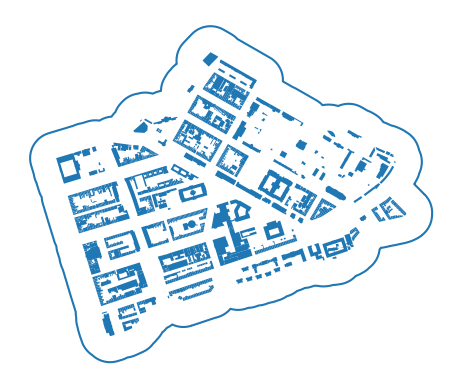

In [9]:
## Adding a buffer around the buildings
limit = mm.buffered_limit(buildings, buffer=100)
limit = gpd.GeoSeries([limit])

# set to what the buildings have 
limit.set_crs(crs=buildings.crs, inplace=True)
ax = limit.boundary.plot()
buildings.plot(ax=ax)
ax.set_axis_off()

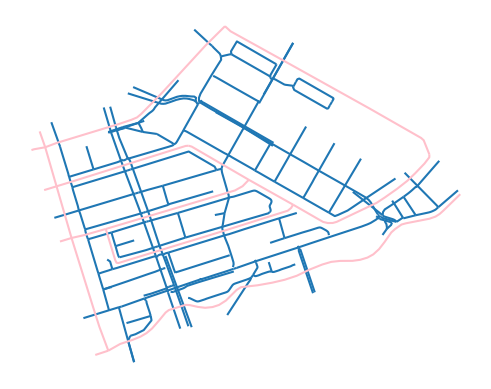

In [10]:
# Extend streets & waterways from gdf to itself or target within a set tolerance
extended_streets = mm.extend_lines(streets, tolerance=120, target=limit, barrier=buildings)
extended_water = mm.extend_lines(waterways, tolerance=120, target=limit, barrier=buildings)

ax = extended_streets.plot()
extended_water.plot(ax=ax, color='pink')
ax.set_axis_off()

/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).
  warnings.warn(


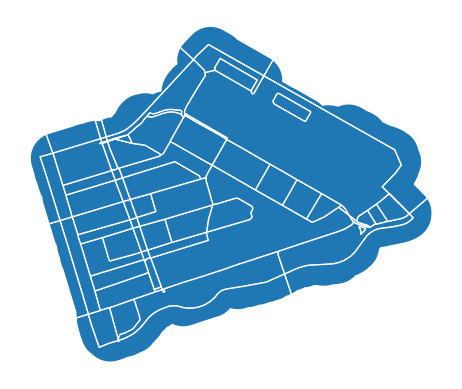

In [11]:
enclosures = mm.enclosures(primary_barriers=extended_streets, additional_barriers=[ams_outline], limit=limit)
ax = enclosures.plot(edgecolor='white')
ax.set_axis_off()

/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Amersfoort / RD New (the single non-null crs provided).
  warnings.warn(


CPU times: user 905 ms, sys: 1.1 s, total: 2.01 s
Wall time: 6.68 s


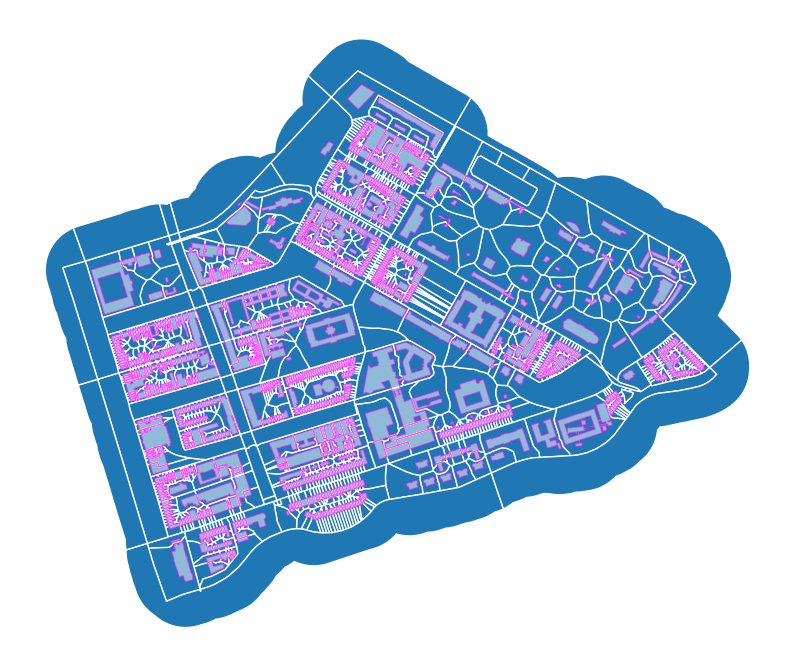

In [12]:
%%time
enclosed_tessellation = mm.Tessellation(buildings, unique_id='uID', enclosures=enclosures, use_dask=True, shrink = 0.1, verbose=True).tessellation

# some post processing, keep only columns of interest
enclosed_tessellation = enclosed_tessellation[['uID','geometry']]

# plot
ax = enclosed_tessellation.plot(figsize=(10, 10), edgecolor='white')
buildings.plot(ax=ax, color='white', alpha=.5, edgecolor='magenta')
ax.set_axis_off()

In [13]:
#### Deal with Empty cells

# if we have empty cells we must give them a 'fake' building id even though they enclose no building
empty_cells_num = len(enclosed_tessellation[enclosed_tessellation.uID.isna()])

if empty_cells_num > 0:
    print(f"We have {empty_cells_num} empty cells")

    enclosed_tessellation = enclosed_tessellation.reset_index(drop=True)
    max_uID = int(enclosed_tessellation.uID.max())
    filler = pd.Series(range((max_uID+1), (max_uID+1)+empty_cells_num), index=enclosed_tessellation[enclosed_tessellation.uID.isna()].index)
    enclosed_tessellation['uID'] = enclosed_tessellation.uID.fillna(filler)



# make sure there are no empty cells without ID
assert not enclosed_tessellation.uID.isna().any()
print("Empty Cells fixed")

enclosed_tessellation['uID'] = enclosed_tessellation['uID'].astype(int)


We have 41 empty cells
Empty Cells fixed


In [14]:
#### Deal with Double Cells: 

# Aka 1 building belongs to more than one cells.
# We would expect 1-to-1 relationship between the buildings and the cells but we sometimes find duplicates. 
# This is the effect of the shrinking applied during the tessellation method
# Shrinking might cause a building footprint to split into two or more polygons,
# resulting in the same number of cells.
# These cells should be merged (dissolve)

enclosed_tessellation = enclosed_tessellation.dissolve(by='uID', as_index=False)

# make sure there are no more duplicates
assert not enclosed_tessellation['uID'].duplicated().any()
print("Buildings with double cells fixed.")

Buildings with double cells fixed.


__FIXING ISSUES. TO BE INTEGRATED ABOVE__

In [15]:
#First we're grabbing all building ids from the building gdf.
# Then we're filtering the tessellation dataframe to see which of the buildings have a tessellation cell.
# This reveals we have a few (1-3) less.
# so we use the building id's in the filtered tessellation df to filter back the buildings
building_filter = list(enclosed_tessellation.uID.loc[enclosed_tessellation.uID.isin(list(buildings.uID))])
buildings = buildings.loc[buildings.uID.isin(building_filter)].copy()


In [ ]:
enclosed_tessellation.explore()

### Tessellation and street based blocks

__Building blocks__ are another morphological element we take into consideration in the further analysis. In order to generate them, we take the tessellation results, the extended road network and the buildings.

The function dissolves the tessellation cells based on street-network based polygons and then links the resulting ID to buildings and tessellation as attributes.

34 blocks created: 


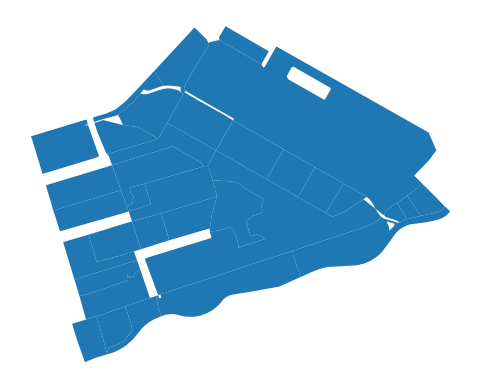

In [16]:
# Create street blocks (morph tess\
blocks = mm.Blocks(enclosed_tessellation, edges=extended_streets, buildings=buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks 
print(f"{len(blocks.blocks)} blocks created: ") 

buildings['bID'] = blocks.buildings_id.values  # get block ID
enclosed_tessellation['bID'] = blocks.tessellation_id.values  # get block ID

ax = blocks_df.plot()
ax.set_axis_off()

<Axes: >

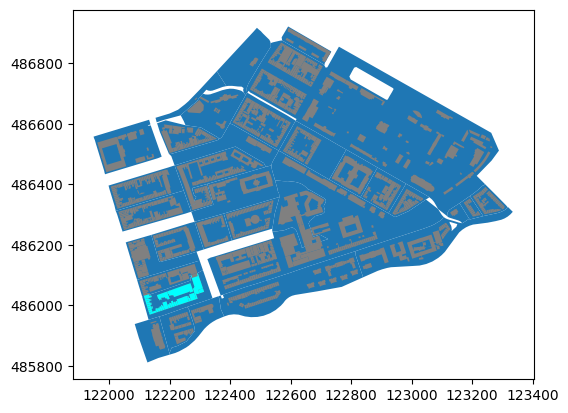

In [17]:
# small verification that all buildings with in a block are selected
kk = buildings[buildings['bID'] == 0]
ax = blocks_df.plot()
buildings.plot(ax=ax, color='gray')
kk.plot(ax=ax, color='cyan')


#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [18]:
tessellation=enclosed_tessellation.copy() 

# Create network ID's
streets["nID"] = range(len(streets))

# Get network ID's for each individual building
buildings['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)

# Merge with tesselation results
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Morphometric assessment

Morphometric characters are measurable traits of morphometric elements, such as the length of wings or dimensions of beaks in biology (hence the 'taxonomy' aspect). 

These characters are crucial for cluster analysis and capture the structural complexity of urban tissues across different scales. The numerical taxonomy approach as proposed by %CITE Fleischmann utilizes six categories of morphometric characters: dimension, shape, spatial distribution, intensity, connectivity, and diversity.

We differentiate between two different types of characters: _primary_ and _contextual_

Primary characters measure the geometry and configuration of buildings, streets, tessellation cells and blocks and their relationships.

In [19]:
blocks = blocks_df

In [20]:
%%time
# %load_ext autoreload
# %autoreload 2

from primary_characteristics import get_primary_characteristics_for_buildings
tessellation, edges, nodes, spatial_weights = get_primary_characteristics_for_buildings(buildings, tessellation, blocks, streets)

Primary characteristics being calculated!


/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/momepy/shape.py:826: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/momepy/shape.py:947: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/momepy/shape.py:1168: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
/Users/lbeuster/Documents/TU Delft/Projects/3dgeo_scalable_gis/.venv/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


Calculation done!
CPU times: user 5.56 s, sys: 50.8 ms, total: 5.61 s
Wall time: 5.6 s


## Measure contextual - spatially lagged characters

The characteristics we calculated describe different morphometric elements (buildings, streets, blocks) and how they relate to each other. However, if we use these characteristics to try and group areas together, we might end up with groups that are not connected spatially. This happens because the city is made up of different types of buildings and shapes, which can make the groups look fragmented. What we need is to take into consideration the elements in their _context_, calculating indicators representative of urban tissue.

To capture urban tissue _context_, we derive contextual characters based on neighboring cells within a defined range. In this case, we define _context_ as cells within third order of contiguity (see below %% CITE FLEISCHMANN).


<div>
<img src="../documents/images/tessellation_cell_context.jpg" width="1000"/>
</div>


The way we the contextual indicators are calculated in the original method:
- merging all of the characteristics we just calculated to the tessellation cell (so we're left with a single dataframe)
- looping through this very long dataframe one by one
- identifying the neighbouring cells and creating a subset of neighbours
- once we have a subset, loop through the primary metrics (~70+) to calculate contextual metrics for each of them

What we calculate for each metric are, the interquartile mean (IQM, the truncated mean of the interquartile range), interquartile range (IQR, the difference between the 75th and 25th percentiles of the data), the Theil Index (traditionally used to assess economic inequality and Simpson Diversity Index (a measure of (species) diversity).


__But__:This is not efficient, but what if you want/need to keep your serial code intact?

This is where `dask.delayed` comes to the rescue

`dask.delayed` is a special wrapper that tells Dask to wait before actually doing a task. It helps break down big tasks into smaller ones that can be done at the same time on different parts of the data.

By using `dask.delayed`, we can make our computations faster and more efficient by doing things in parallel.

In [21]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID', how='left')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

primary = merged.drop(columns=['nID','bID', 'nodeID', 'mm_len', 'cdsbool', 
                               'node_start', 'node_end', 'geometry', 'floor_area',
                               ])
primary.head()

In [41]:
%%time
%load_ext autoreload
%autoreload 2

from contextual_characteristics import get_contextual_characteristics_for_buildings
data = get_contextual_characteristics_for_buildings(primary=primary, buildings=buildings, spatial_weights=spatial_weights,serial=True,n_workers=8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Contextual characteristics being calculated!


  0%|          | 0/1090 [00:00<?, ?it/s]

Calculation done!
CPU times: user 25.2 s, sys: 8.55 s, total: 33.8 s
Wall time: 21.6 s


## Clustering

We use contextual characters to do GMM clustering.

A Gaussian mixture model is a distance based probabilistic model that assumes all the data points are generated from a linear combination of multivariate Gaussian distributions with unknown parameters.

The key steps performed in this model are:

1. Initialize k gaussian distributions
2. Calculate probabilities of each point’s association with each of the distributions
3. Recalculate distribution parameters based on each point’s probabilities associated with the the distributions
4. Repeat process till log-likelihood is maximized


In the original method, we use a Gaussian Mixture Model as the clustering algorithm. 


__Comparison between Gaussian and K-means:__


Gaussian Mixture Model (GMM) and K-means are both clustering algorithms, but they have some differences.

K-means is a simple and intuitive algorithm that aims to partition the data into a predetermined number of clusters. It assigns each data point to the nearest centroid, iteratively optimizing the centroids to minimize the sum of squared distances within each cluster. K-means is computationally efficient and works well when clusters have a spherical shape and similar sizes.

On the other hand, Gaussian Mixture Model (GMM) is a probabilistic model that assumes the data points are generated from a mixture of Gaussian distributions. It estimates the parameters of these Gaussian distributions to fit the data. GMM allows for more flexible cluster shapes and can capture clusters with different sizes and orientations. It also provides a measure of uncertainty, as each data point is assigned a probability of belonging to each cluster.

In summary, K-means is a simpler and computationally efficient algorithm that works well for spherical clusters, while GMM is a probabilistic model that provides more flexibility in cluster shapes and captures uncertainty in the assignment of data points to clusters. The choice between the two depends on the nature of the data and the specific requirements of the problem at hand.

---

The choice between Gaussian Mixture Model (GMM) and K-means can depend on various factors, including the nature of the data and the requirements of the problem. Here are some examples of dependencies that can influence the selection:

Cluster Shape: If the clusters in the data have different shapes and orientations, GMM may be more suitable as it can model clusters with different covariance structures. K-means assumes spherical clusters, so it may struggle to capture complex shapes.

Cluster Size and Density: GMM can handle clusters of different sizes and densities effectively. If the clusters in the data have varying sizes or significantly different densities, GMM is more likely to provide better results compared to K-means.

Uncertainty and Soft Assignment: GMM provides soft assignments by assigning probabilities of data points belonging to each cluster. If there is ambiguity or uncertainty in the data points' membership to clusters, GMM can capture it. K-means, on the other hand, provides hard assignments, assigning each data point exclusively to a single cluster.

Computational Efficiency: K-means is generally faster and computationally more efficient compared to GMM, especially when dealing with large datasets. If computational efficiency is a critical requirement, K-means might be preferred.

Interpretability and Simplicity: K-means is easier to interpret as it assigns data points to discrete clusters. The resulting centroids can be meaningful representations of the clusters. GMM, with its probabilistic nature, provides more complex representations of clusters, which may require additional analysis or interpretation.

Outlier Sensitivity: K-means is sensitive to outliers as they can significantly affect the positions of the cluster centroids. GMM, with its probabilistic framework, is more robust to outliers as it models data points as probabilities.

Predefined Number of Clusters: If the desired number of clusters is known or predetermined, K-means can be a suitable choice. GMM, on the other hand, can automatically determine the optimal number of clusters based on statistical criteria like Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC).

It's important to carefully analyze the data, consider the specific problem requirements, and experiment with both algorithms to determine which one provides the best results for a given task.

### Kmeans clustering

In [35]:
# normalise data
x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])

# Create the dataframe for the Bayesian information criterion (bic), a criterion for model selection.
inertia = pd.DataFrame(columns=['n', 'inertia', 'run'])
ix = 0

# specify range you want to assess. 2-8 should be sensible for the sample. Adjust depending on sample.
n_clusters_range = range(2, 20)

# specify how many times should each option be tried (more better, but takes a long time)
kmeans_runs = 1

# Fill NAN so we don't encounter errors
data = data.fillna(0)

# Execute K-means clustering, with the number of clusters as defined prior
for n_clusters in n_clusters_range:
    for i in range(kmeans_runs):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        fitted = kmeans.fit(data)
        inertianum = kmeans.inertia_  # BIC is not applicable for k-means, so we use inertia_ as a measure
        inertia.loc[ix] = [n_clusters, inertianum, i]
        ix += 1

        print(n_clusters, i, "Inertia:", inertianum)


2 0 Inertia: 231895.0616293226
3 0 Inertia: 208740.59821955534
4 0 Inertia: 191847.17322784816
5 0 Inertia: 182074.8536682835
6 0 Inertia: 172773.16393315067
7 0 Inertia: 161389.15218271065
8 0 Inertia: 155899.3440275005
9 0 Inertia: 146083.28862778333
10 0 Inertia: 140650.49512742352
11 0 Inertia: 133926.41805322398
12 0 Inertia: 129957.33565751358
13 0 Inertia: 124421.30241247908
14 0 Inertia: 118909.31446191303
15 0 Inertia: 115376.16273145378
16 0 Inertia: 112992.5787548083
17 0 Inertia: 109954.25614557584
18 0 Inertia: 106917.87984654782
19 0 Inertia: 104759.54872938871


<Axes: xlabel='n', ylabel='inertia'>

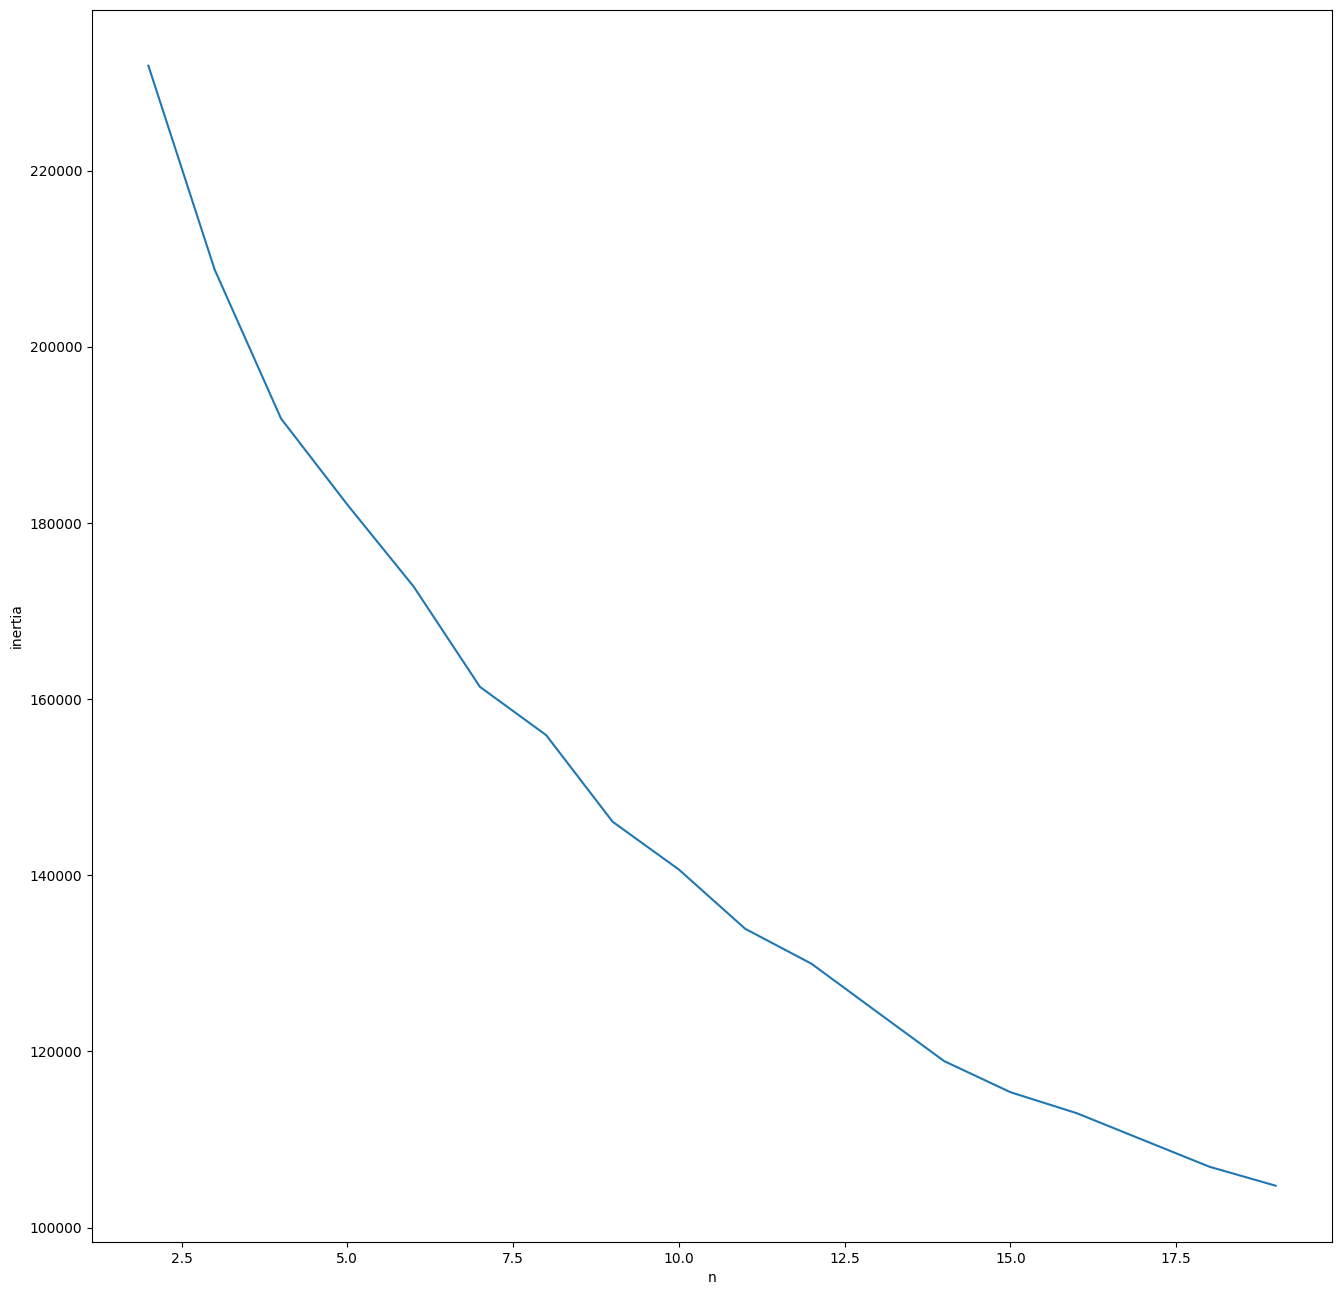

In [36]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='inertia', data=inertia)
# plt.savefig('../files/complete_BIC.pdf')

In [37]:
n = 4  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init = 10  # more initialization, more stable clustering gets

kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=n_init, random_state=0)
fitted = kmeans.fit(data)

labels = kmeans.predict(data)

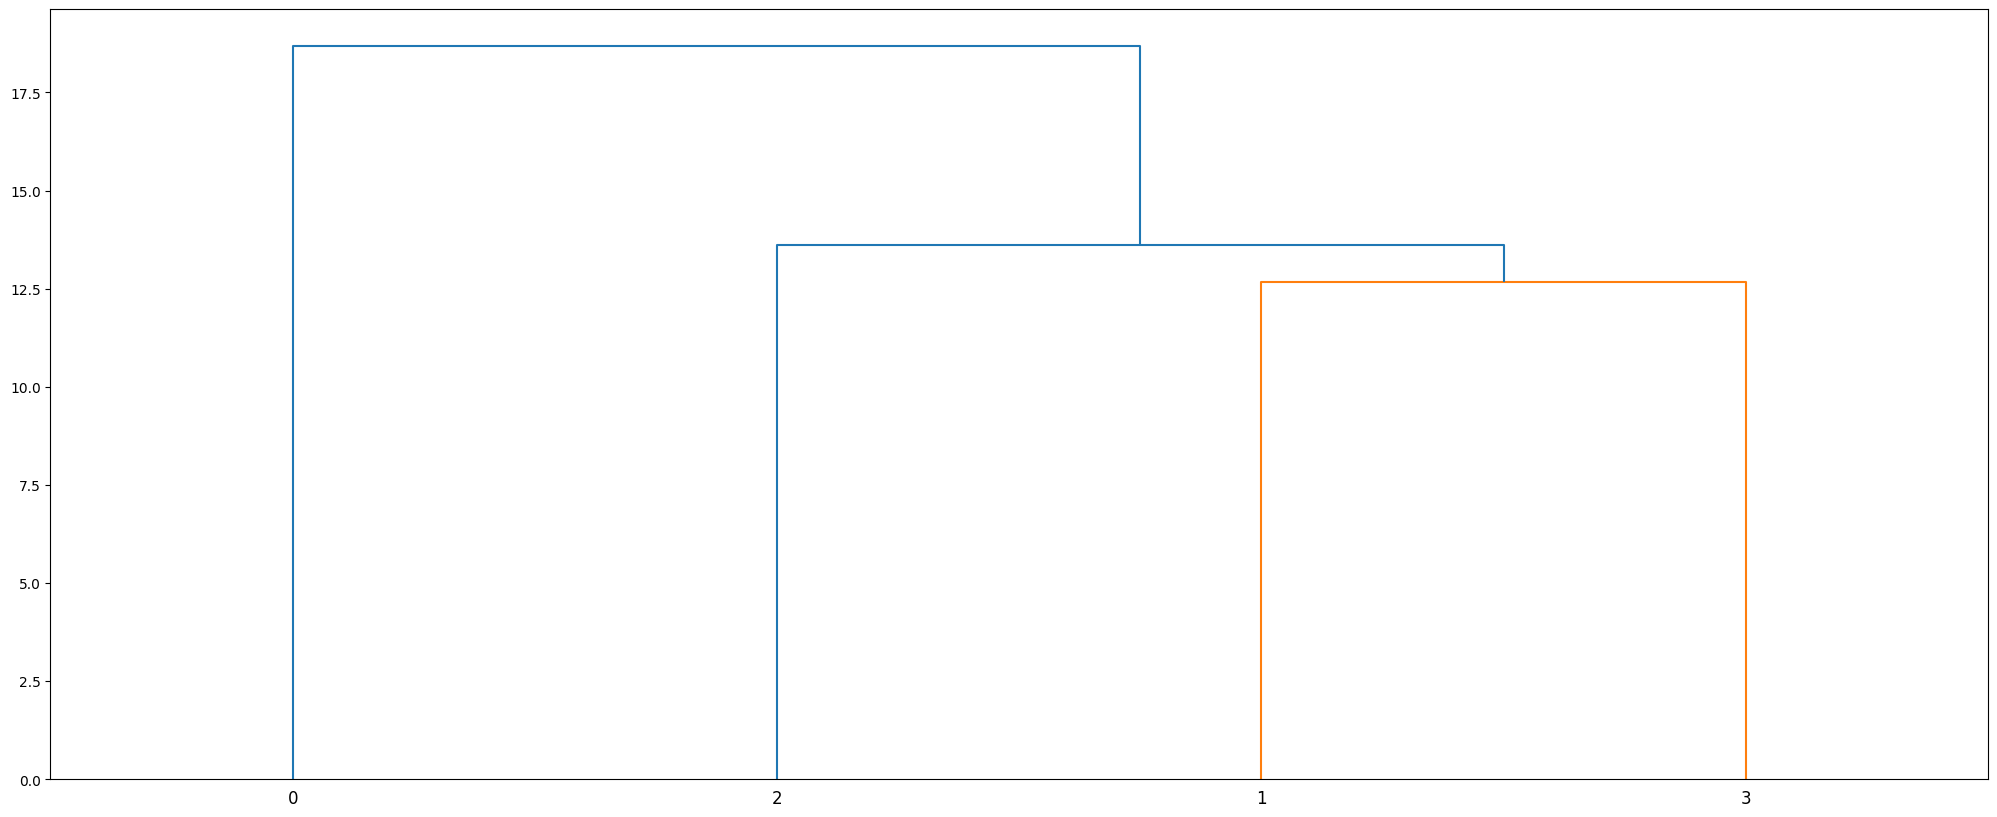

In [39]:
group = data.groupby(labels).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

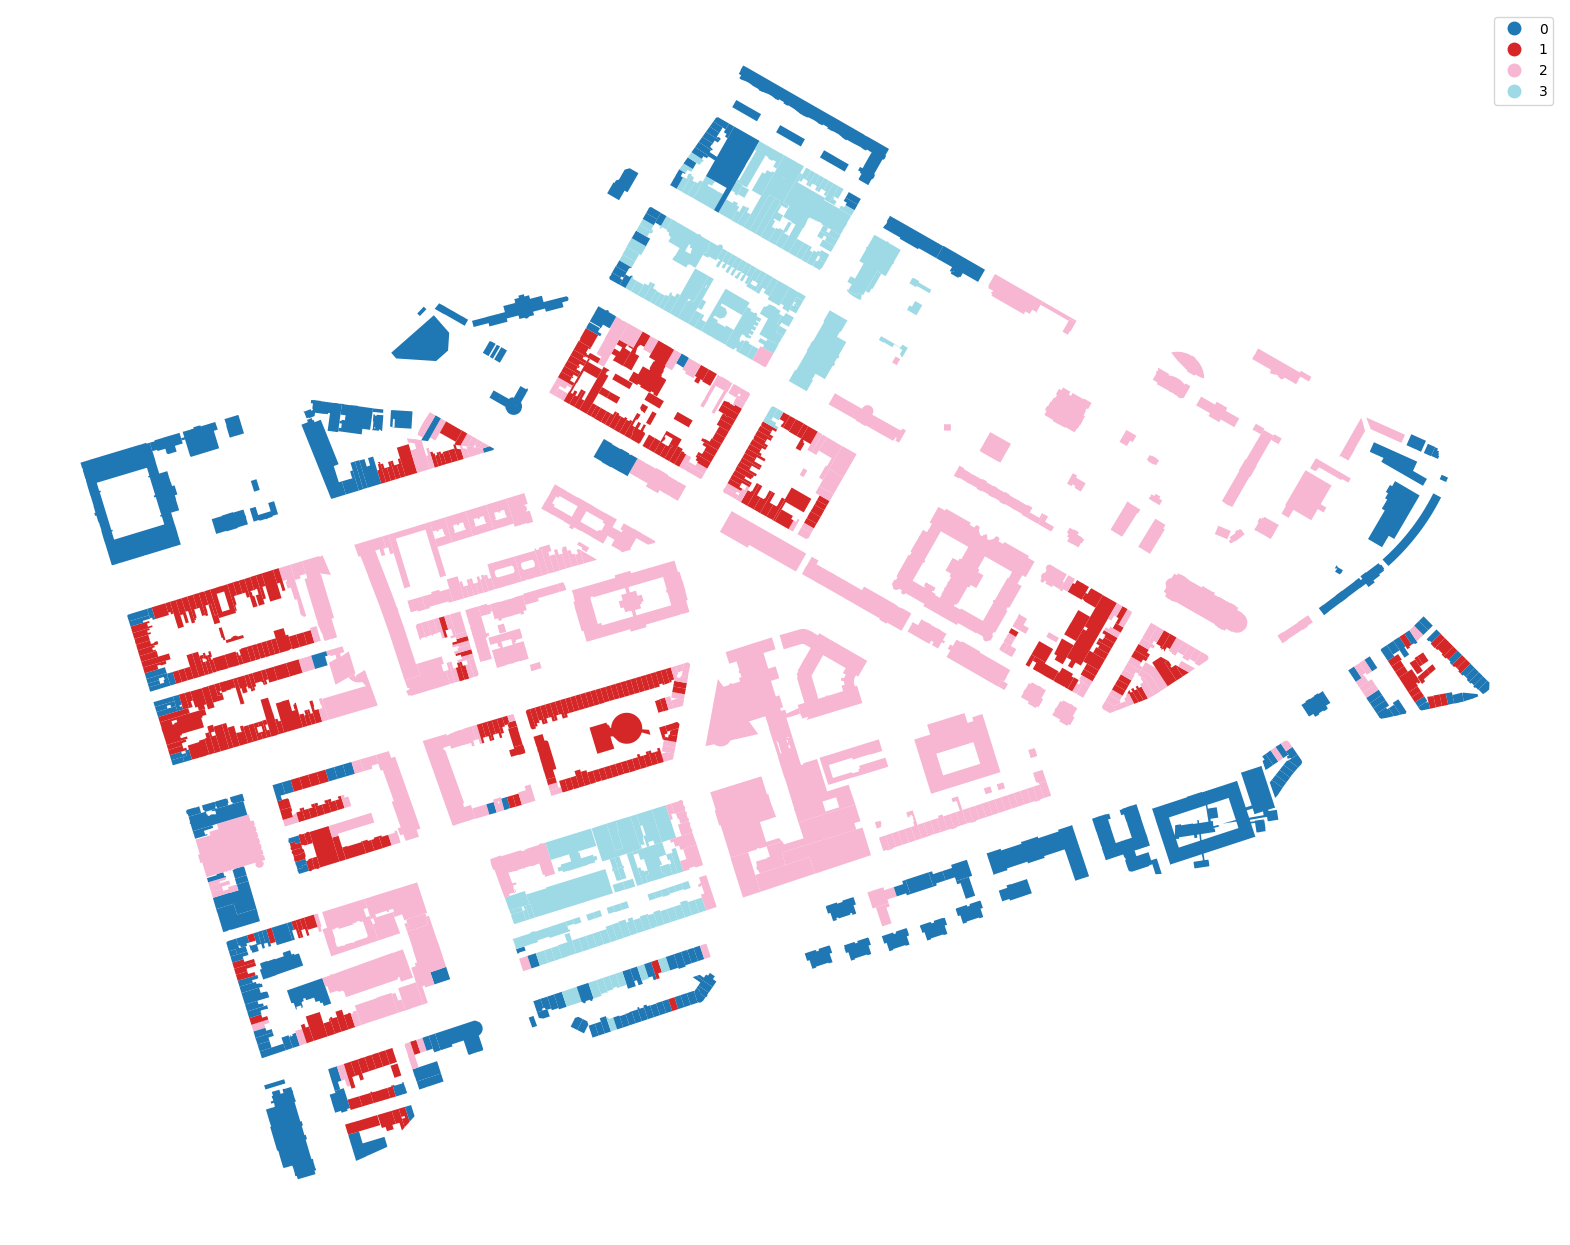

In [40]:
ax = buildings.plot(labels, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))
ax.set_axis_off()
# plt.savefig('../results/figures/Ams_taxonomy_sample_kmeans.jpg', dpi=600)